In [1]:
%load_ext autoreload
%autoreload 2

import datajoint as dj
dj.config["enable_python_native_blobs"] = True
dj.config['nnfabrik.schema_name'] = "nnfabrik_v1_tuning"
schema = dj.schema("nnfabrik_v1_tuning")

import os
from os import listdir
from os.path import isfile, join


import torch
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import seaborn as sns

import nnfabrik
from nnfabrik import main, builder
from nnfabrik.main import *

import nnvision
from nnvision.tables.from_nnfabrik import TrainedModel
from nnvision.tables.legacy.from_mei import TrainedEnsembleModel

import insilico_stimuli
from insilico_stimuli.stimuli import *
from insilico_stimuli.parameters import *

Connecting pawelp@134.2.168.16:3306


In [2]:
def get_monkey_model(data_key):
    # loading model
    model_hash = 'f8bcd882c48a55dc6cd6d7afb656f1f9'

    model_key = (TrainedModel & dict(model_hash=model_hash)).fetch("KEY", limit=1, order_by="score DESC")
    dataloaders, model = TrainedModel().load_model(model_key, include_dataloader=True)
    model.eval()

    # number of model neurons 
    n_units = model.readout[data_key].outdims

    # image dimensions
    w, h = 41, 41
    
    return model, n_units, w, h, data_key, dataloaders

model, n_units, w, h, data_key, dataloaders = get_monkey_model(data_key='3631807112901')

Loading images ...


In [3]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 10)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 10)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 10)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 5)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [4]:
best_params, values = gabor_set.find_optimal_stimulus_bruteforce(model=model, data_key=data_key, batch_size=1000)

100%|██████████| 480/480 [09:37<00:00,  1.20s/it]


In [12]:
for best_param in best_params:
    best_param['location_width'] = best_param['location'][0]
    best_param['location_height'] = best_param['location'][1]

In [193]:
def get_responses(model, data_key, best_params_list, gabor_set, n_units):
    for unit in tqdm(range(n_units)):
        best_gabor_img = gabor_set.get_image_from_params(best_params_list[unit])
        image = torch.tensor(best_gabor_img)
        image = image.expand(1, 1, w, h).float()

        response = model(image, data_key=data_key).detach().numpy().squeeze()

        
        yield response

responses = np.array(list(get_responses(model, data_key, best_params, gabor_set, n_units)))

100%|██████████| 29/29 [00:01<00:00, 19.93it/s]


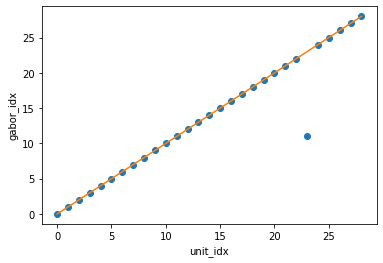

In [198]:
plt.scatter(np.arange(len(responses)), np.array(responses).argmax(0))
plt.plot(np.arange(len(responses)), np.arange(len(responses)), c='tab:orange')
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.show()

In [196]:
responses[]

array([0.2458064 , 0.47503626, 1.3844995 , 2.2319994 , 0.23035324,
       0.44811416, 0.4589622 , 0.3893776 , 1.8333445 , 1.2556776 ,
       2.033861  , 2.8540814 , 1.1406413 , 2.0748746 , 1.3255811 ,
       0.4541157 , 0.32787728, 1.9689636 , 2.649971  , 0.48921287,
       1.1107441 , 0.31926614, 0.29263902, 2.8540814 , 2.4699538 ,
       2.0165405 , 2.307695  , 2.758275  , 2.568571  ], dtype=float32)

In [66]:
# Finite Set
canvas_size         = [w, h]
sizes               = FiniteParameter([float(val) for val in range(5, 31)][::5])
spatial_frequencies = FiniteParameter([float(val) for val in np.linspace(1/80, 2/5, 3)])
contrasts           = FiniteParameter([.5])
orientations        = FiniteParameter([float(val) for val in np.linspace(0.0, np.pi, 3)])
phases              = FiniteParameter([float(val) for val in np.linspace(0.0, 2*np.pi, 3)]) 
grey_levels         = FiniteParameter([0.0])
eccentricities      = FiniteParameter([float(val) for val in np.linspace(0.0, 0.99, 3)])
locations           = FiniteParameter([[float(x), float(y)] for x in range(12, 28) 
                                                            for y in range(12, 28)][::16])

gabor_set = GaborSet(canvas_size=canvas_size,
                     locations=locations,
                     sizes=sizes,
                     spatial_frequencies=spatial_frequencies,
                     contrasts=contrasts,
                     orientations=orientations, 
                     phases=phases, 
                     grey_levels=grey_levels,
                     eccentricities=eccentricities)

In [100]:
n_images = np.prod(gabor_set.num_params())  # number of all parameter combinations
n_units = model.readout[data_key].outdims  # number of units

max_act_evo = np.zeros((n_images + 1, n_units))  # init storage of maximal activation evolution

argmax_activations = np.zeros(n_units).astype(int)
max_activations = np.zeros(n_units)

In [126]:
batch_size = 100

for batch_idx, batch in tqdm(enumerate(gabor_set.image_batches(batch_size)), total=n_images//batch_size):
    if batch.shape[0] != batch_size:
        batch_size = batch.shape[0]
        
    images_batch = batch.reshape((batch_size,) + tuple(gabor_set.canvas_size))
    images_batch = np.expand_dims(images_batch, axis=1)
    images_batch = torch.tensor(images_batch).float()
    activations_batch = model(images_batch, data_key=data_key).detach().numpy().squeeze()
    
    new_max_idx = activations_batch.argmax(0)
    new_max_activations = activations_batch[new_max_idx, range(len(new_max_idx))]
    
    argmax_activations[new_max_activations > max_activations] = new_max_idx[new_max_activations > max_activations] + batch_size * batch_idx
    max_activations[new_max_activations > max_activations] = new_max_activations[new_max_activations > max_activations]
    print(new_max_idx[14], new_max_activations[14], argmax_activations[14], max_activations[14])

  1%|▏         | 1/77 [00:00<00:22,  3.43it/s]

36 1.4849128 2362 2.809134006500244


  3%|▎         | 2/77 [00:00<00:21,  3.51it/s]

65 1.6710386 2362 2.809134006500244


  4%|▍         | 3/77 [00:00<00:20,  3.66it/s]

46 1.9444044 2362 2.809134006500244


  5%|▌         | 4/77 [00:01<00:19,  3.69it/s]

36 2.2122636 2362 2.809134006500244


  6%|▋         | 5/77 [00:01<00:20,  3.57it/s]

17 2.4370284 2362 2.809134006500244


  8%|▊         | 6/77 [00:01<00:18,  3.76it/s]

70 1.5305611 2362 2.809134006500244


  9%|▉         | 7/77 [00:01<00:18,  3.85it/s]

51 1.763059 2362 2.809134006500244


 10%|█         | 8/77 [00:02<00:17,  3.98it/s]

41 2.0654397 2362 2.809134006500244


 12%|█▏        | 9/77 [00:02<00:17,  3.91it/s]

22 2.3395305 2362 2.809134006500244


 13%|█▎        | 10/77 [00:02<00:17,  3.91it/s]

3 2.5574412 2362 2.809134006500244


 14%|█▍        | 11/77 [00:02<00:17,  3.87it/s]

56 1.5941608 2362 2.809134006500244


 16%|█▌        | 12/77 [00:03<00:16,  3.83it/s]

46 1.8734581 2362 2.809134006500244


 17%|█▋        | 13/77 [00:03<00:16,  3.85it/s]

99 2.3155842 2362 2.809134006500244


 18%|█▊        | 14/77 [00:03<00:16,  3.73it/s]

90 2.6582751 2362 2.809134006500244


 19%|█▉        | 15/77 [00:03<00:16,  3.75it/s]

0 1.5552233 2362 2.809134006500244


 21%|██        | 16/77 [00:04<00:16,  3.73it/s]

42 1.6851251 2362 2.809134006500244


 22%|██▏       | 17/77 [00:04<00:15,  3.86it/s]

32 1.9927319 2362 2.809134006500244


 23%|██▎       | 18/77 [00:04<00:14,  3.95it/s]

95 2.5500567 2362 2.809134006500244


 25%|██▍       | 19/77 [00:04<00:14,  3.97it/s]

76 2.7638507 2362 2.809134006500244


 26%|██▌       | 20/77 [00:05<00:14,  3.98it/s]

56 1.5580908 2362 2.809134006500244


 27%|██▋       | 21/77 [00:05<00:14,  3.91it/s]

37 1.7876179 2362 2.809134006500244


 29%|██▊       | 22/77 [00:05<00:13,  3.97it/s]

99 2.3795514 2362 2.809134006500244


 30%|██▉       | 23/77 [00:05<00:13,  4.01it/s]

81 2.6359801 2362 2.809134006500244


 31%|███       | 24/77 [00:06<00:13,  3.99it/s]

62 2.809134 2362 2.809134006500244


 32%|███▏      | 25/77 [00:06<00:13,  3.90it/s]

42 1.5990326 2362 2.809134006500244


 34%|███▍      | 26/77 [00:06<00:13,  3.88it/s]

95 2.1170619 2362 2.809134006500244


 35%|███▌      | 27/77 [00:06<00:12,  3.91it/s]

86 2.4323814 2362 2.809134006500244


 36%|███▋      | 28/77 [00:07<00:12,  3.93it/s]

67 2.6493585 2362 2.809134006500244


 38%|███▊      | 29/77 [00:07<00:12,  3.90it/s]

48 2.77842 2362 2.809134006500244


 39%|███▉      | 30/77 [00:07<00:12,  3.83it/s]

28 1.6090064 2362 2.809134006500244


 42%|████▏     | 32/77 [00:08<00:10,  4.20it/s]

91 2.1502187 2362 2.809134006500244
72 2.4082277 2362 2.809134006500244


 43%|████▎     | 33/77 [00:08<00:10,  4.20it/s]

53 2.577605 2362 2.809134006500244


 44%|████▍     | 34/77 [00:08<00:10,  4.26it/s]

34 2.668302 2362 2.809134006500244


 45%|████▌     | 35/77 [00:08<00:09,  4.26it/s]

95 1.8270743 2362 2.809134006500244


 47%|████▋     | 36/77 [00:09<00:09,  4.34it/s]

77 2.085215 2362 2.809134006500244


 48%|████▊     | 37/77 [00:09<00:09,  4.35it/s]

58 2.298025 2362 2.809134006500244


 49%|████▉     | 38/77 [00:09<00:09,  4.31it/s]

39 2.4247618 2362 2.809134006500244


 51%|█████     | 39/77 [00:09<00:09,  4.06it/s]

20 2.4877198 2362 2.809134006500244


 52%|█████▏    | 40/77 [00:10<00:09,  3.94it/s]

81 1.7506394 2362 2.809134006500244


 53%|█████▎    | 41/77 [00:10<00:09,  4.00it/s]

63 1.963037 2362 2.809134006500244


 55%|█████▍    | 42/77 [00:10<00:08,  4.02it/s]

44 2.125091 2362 2.809134006500244


 56%|█████▌    | 43/77 [00:10<00:08,  3.97it/s]

25 2.2173555 2362 2.809134006500244


 57%|█████▋    | 44/77 [00:11<00:08,  3.94it/s]

6 2.2620728 2362 2.809134006500244


 58%|█████▊    | 45/77 [00:11<00:08,  3.87it/s]

67 1.6434348 2362 2.809134006500244


 60%|█████▉    | 46/77 [00:11<00:07,  3.93it/s]

49 1.8067439 2362 2.809134006500244


 61%|██████    | 47/77 [00:11<00:07,  4.08it/s]

30 1.9252095 2362 2.809134006500244


 62%|██████▏   | 48/77 [00:12<00:06,  4.16it/s]

92 2.022107 2362 2.809134006500244


 64%|██████▎   | 49/77 [00:12<00:07,  3.94it/s]

0 1.6990737 2362 2.809134006500244


 65%|██████▍   | 50/77 [00:12<00:06,  3.91it/s]

54 1.5205414 2362 2.809134006500244


 66%|██████▌   | 51/77 [00:12<00:06,  4.06it/s]

35 1.6338406 2362 2.809134006500244


 68%|██████▊   | 52/77 [00:13<00:06,  3.96it/s]

97 1.7648525 2362 2.809134006500244


 69%|██████▉   | 53/77 [00:13<00:05,  4.01it/s]

79 1.81639 2362 2.809134006500244


 70%|███████   | 54/77 [00:13<00:05,  3.98it/s]

6 1.6288905 2362 2.809134006500244


 71%|███████▏  | 55/77 [00:13<00:05,  4.04it/s]

95 1.4917223 2362 2.809134006500244


 73%|███████▎  | 56/77 [00:14<00:04,  4.24it/s]

99 1.737895 2362 2.809134006500244


 74%|███████▍  | 57/77 [00:14<00:04,  4.28it/s]

80 1.8109528 2362 2.809134006500244


 75%|███████▌  | 58/77 [00:14<00:04,  4.35it/s]

61 1.8495424 2362 2.809134006500244


 77%|███████▋  | 59/77 [00:14<00:04,  4.13it/s]

0 1.5349412 2362 2.809134006500244


 78%|███████▊  | 60/77 [00:15<00:04,  4.08it/s]

94 1.7152143 2362 2.809134006500244


 79%|███████▉  | 61/77 [00:15<00:03,  4.19it/s]

85 1.9483032 2362 2.809134006500244


 81%|████████  | 62/77 [00:15<00:03,  4.21it/s]

66 2.0073943 2362 2.809134006500244


 82%|████████▏ | 63/77 [00:15<00:03,  4.30it/s]

47 2.02526 2362 2.809134006500244


 83%|████████▎ | 64/77 [00:15<00:03,  4.26it/s]

99 1.7312143 2362 2.809134006500244


 84%|████████▍ | 65/77 [00:16<00:02,  4.28it/s]

90 2.0194514 2362 2.809134006500244


 87%|████████▋ | 67/77 [00:16<00:02,  4.52it/s]

71 2.1722033 2362 2.809134006500244
52 2.2187386 2362 2.809134006500244


 88%|████████▊ | 68/77 [00:16<00:02,  4.42it/s]

34 2.2391179 2362 2.809134006500244


 90%|████████▉ | 69/77 [00:17<00:01,  4.32it/s]

94 1.8983072 2362 2.809134006500244


 91%|█████████ | 70/77 [00:17<00:01,  4.41it/s]

76 2.2132993 2362 2.809134006500244


 92%|█████████▏| 71/77 [00:17<00:01,  4.24it/s]

57 2.382669 2362 2.809134006500244


 94%|█████████▎| 72/77 [00:17<00:01,  4.31it/s]

38 2.4248962 2362 2.809134006500244


 95%|█████████▍| 73/77 [00:18<00:00,  4.15it/s]

19 2.4088182 2362 2.809134006500244


 96%|█████████▌| 74/77 [00:18<00:00,  4.00it/s]

80 2.0063941 2362 2.809134006500244


 97%|█████████▋| 75/77 [00:18<00:00,  3.91it/s]

62 2.3406932 2362 2.809134006500244


 99%|█████████▊| 76/77 [00:18<00:00,  4.00it/s]

43 2.5281935 2362 2.809134006500244


100%|██████████| 77/77 [00:19<00:00,  4.02it/s]

24 2.5833752 2362 2.809134006500244


78it [00:19,  4.04it/s]                        

5 2.571495 2362 2.809134006500244


In [130]:
for i, act in enumerate(argmax_activations):
    print(i, act, max_activations[i])

0 2386 1.5385682582855225
1 4711 3.530632495880127
2 2362 6.471563339233398
3 3325 1.9620988368988037
4 3844 0.5160417556762695
5 3357 3.5142745971679688
6 4306 4.167010307312012
7 7048 3.544290065765381
8 4792 2.6409525871276855
9 5787 1.7902405261993408
10 6733 3.234736204147339
11 4329 2.459527015686035
12 1297 1.6471872329711914
13 4711 2.650205135345459
14 2362 2.809134006500244
15 3811 0.6851619482040405
16 4306 3.7172889709472656
17 2757 2.3846678733825684
18 3843 1.204512119293213
19 5683 3.543862819671631
20 6736 0.6416008472442627
21 1873 1.6716537475585938
22 2677 1.9756301641464233
23 3334 0.5127195119857788
24 3649 1.1462912559509277
25 2683 0.2861940860748291
26 2191 0.1951480507850647
27 2848 0.9392144083976746
28 6734 0.5643815398216248


In [123]:
params = [None] * n_units  # init list with parameter dictionaries
for unit, opt_param_idx in enumerate(argmax_activations):
    params[unit] = gabor_set.params_dict_from_idx(opt_param_idx)
    params[unit]['location_width'] = params[unit]['location'][0]
    params[unit]['location_height'] = params[unit]['location'][1]

In [168]:
def get_responses(model, data_key, best_params_list, gabor_set, n_units):
    for unit in tqdm(range(n_units)):
        best_gabor_img = gabor_set.get_image_from_params(best_params_list[unit])
        image = torch.tensor(best_gabor_img)
        image = image.expand(1, 1, w, h).float()

        response = model(image, data_key=data_key).detach().numpy().squeeze()
        print(unit, response[14])
        
        yield response

responses = np.array(list(get_responses(model, data_key, params, gabor_set, n_units)))

 14%|█▍        | 4/29 [00:00<00:01, 17.94it/s]

0 1.4947119
1 1.9905772
2 2.8091338
3 2.046333
4 1.3804504


 28%|██▊       | 8/29 [00:00<00:01, 18.69it/s]

5 1.4135914
6 2.262073
7 1.9715703
8 2.022107


 41%|████▏     | 12/29 [00:00<00:00, 18.90it/s]

9 1.4544398
10 2.2164295
11 1.4286437
12 1.0195343


 55%|█████▌    | 16/29 [00:00<00:00, 19.19it/s]

13 1.9905772
14 2.8091338
15 1.9231515
16 2.262073


 69%|██████▉   | 20/29 [00:01<00:00, 19.34it/s]

17 2.3092673
18 1.3891302
19 1.5546594
20 1.2459147
21 1.1850526


 86%|████████▌ | 25/29 [00:01<00:00, 19.57it/s]

22 2.155259
23 2.668302
24 1.9950479
25 1.232087


100%|██████████| 29/29 [00:01<00:00, 19.38it/s]

26 2.1596901
27 2.7784202
28 2.2391179


In [182]:
print(best_params[2])
print(best_params[14])

{'location': [20.0, 12.0], 'size': 30.0, 'spatial_frequency': 0.05555555555555555, 'contrast': 0.5, 'orientation': 1.7453292519943295, 'phase': 2.792526803190927, 'gamma': 1.0, 'grey_level': 0.0, 'location_width': 20.0, 'location_height': 12.0}
{'location': [26.0, 12.0], 'size': 30.0, 'spatial_frequency': 0.05555555555555555, 'contrast': 0.5, 'orientation': 1.7453292519943295, 'phase': 0.6981317007977318, 'gamma': 1.0, 'grey_level': 0.0, 'location_width': 26.0, 'location_height': 12.0}


In [181]:
param = gabor_set.params_dict_from_idx(argmax_activations[2])
param['location_width'] = param['location'][0]
param['location_height'] = param['location'][1]

best_gabor_img = gabor_set.get_image_from_params(param)
image = torch.tensor(best_gabor_img)
image = image.expand(1, 1, w, h).float()

response = model(image, data_key=data_key).detach().numpy().squeeze()

print(response)

[1.3414493  3.291411   6.4715633  1.8404382  0.45525503 1.5158104
 4.017432   3.3237853  2.5116642  1.5649728  2.6781077  2.0257502
 1.4092338  2.3767889  2.8091338  0.6172382  3.529732   2.3741393
 0.9456273  2.7250066  0.37352693 0.12308645 1.853334   0.48378766
 0.8290149  0.02591443 0.12990904 0.9066149  0.5494209 ]


In [228]:
c1 = []
c2 = []
for response in np.array(responses).T:
    if len(np.array(response)[np.array(response) == np.array(response).max()]) == 1:
        c1.append('tab:blue')
        c2.append('#fff')
    else:
        c1.append('tab:blue')
        c2.append('tab:red')
        
c = c1 + c2

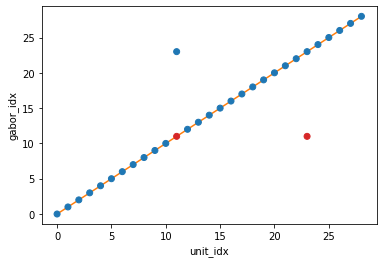

In [232]:
plt.plot(np.arange(len(responses)), np.arange(len(responses)), c='tab:orange')
plt.scatter([np.arange(len(responses))]*2, np.array(responses).argsort(0)[::-1][:2], c=c, zorder=10)
plt.xlabel('unit_idx')
plt.ylabel('gabor_idx')
plt.show()

In [245]:
for unit, response in enumerate(np.array(responses).T):
    if not np.any(np.where(response == response.max())[0] == unit):
        print('failed')
        break

In [5]:
from nnidentify.fitgabor.fitgabor import GaborGenerator, trainer_fn

In [9]:
gab_gen = GaborGenerator((h, w))

def neuron(x, *args, **kwargs):
    return model(x, data_key='3631807112901', *args, **kwargs)[:, 0]

gab_gen, _ = trainer_fn(gab_gen, neuron, epochs=300, lr=0.01, fixed_std=0.1)

Loss: -1.58: 100%|██████████| 300/300 [00:09<00:00, 32.24it/s]


In [31]:
gd_imgs = []
for i in range(10):
    def neuron(x, *args, **kwargs):
        return model(x, data_key='3631807112901', *args, **kwargs)[:, i]

    gab_gen, _ = trainer_fn(gab_gen, neuron, epochs=1000, lr=0.01, fixed_std=0.1)
    gd_imgs.append(gab_gen())

Loss: -2.40: 100%|██████████| 1000/1000 [00:16<00:00, 61.63it/s]


100%|██████████| 10/10 [00:00<00:00, 440.25it/s]


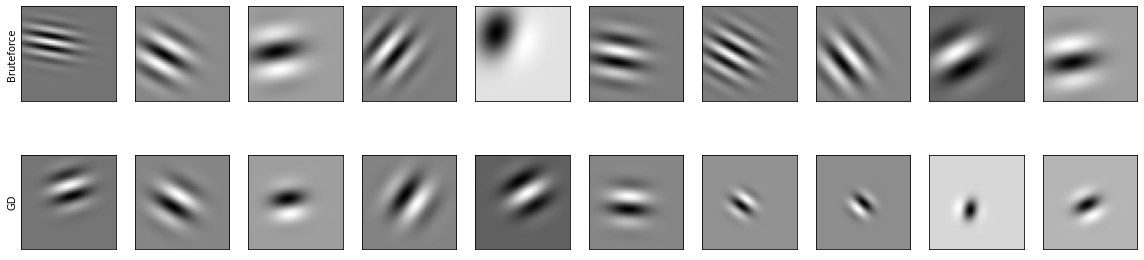

In [33]:
fig, axs = plt.subplots(2, 10, figsize=(20, 5))

axs[0, 0].set_ylabel('Bruteforce')
axs[1, 0].set_ylabel('GD')

for unit in tqdm(range(10)):
    best_gabor_img = gabor_set.get_image_from_params(best_params[unit])
    axs[0, unit].imshow(best_gabor_img, cmap='gray')
    axs[0, unit].set_xticks([])
    axs[0, unit].set_yticks([])
    
    axs[1, unit].imshow(gd_imgs[unit].squeeze().detach().numpy(), cmap='gray')
    axs[1, unit].set_xticks([])
    axs[1, unit].set_yticks([])
    
plt.savefig('imgs/bruteforce_vs_GD.png')
plt.show()

## Plot Gabors

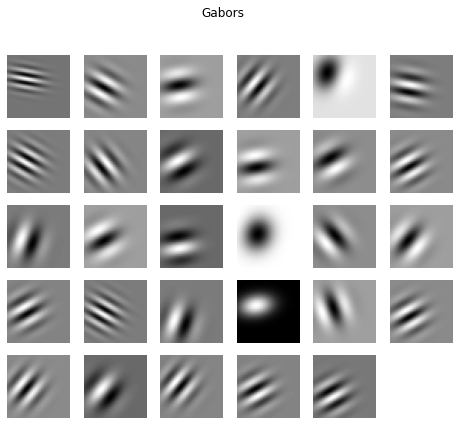

In [36]:
fig, axs = plt.subplots(5, 6, figsize=(8, 6.67))

axs.ravel()[-1].axis('off')

for i, ax in enumerate(axs.ravel()[:-1]):
    best_gabor_img = gabor_set.get_image_from_params(best_params[i])
    ax.imshow(best_gabor_img, cmap="gray")
    ax.axis("off")
    
plt.suptitle('Gabors')
plt.savefig('gabors.png', dpi=300)
plt.show()